In [1]:
import importlib
import numpy as np
from matplotlib import pyplot as plt

import sys
# sys.path.append('/home/otps3141/Documents/Dokumente/ETH QE/Master Thesis Imperial/Thesis/Code/OBEsimulation/MEVeS_new')
import libs.MEVeS as S
import libs.AtomicConstants.Atom as AC

# import Optimiser as Opt
# importlib.reload(Opt)
import timeit
from scipy.optimize import curve_fit
import json
import pandas as pd

import os 

from tqdm import tqdm

plt.ion()
%matplotlib widget

In [2]:
# os.path.abspath('')

In [3]:
# os.path.abspath('').find('MEVeS_new')

In [4]:
# os.path.abspath('')[:os.path.abspath('').find('MEVeS_new') + len('MEVeS_new')]

# Normal ORCA

In [5]:

# Make atom class

config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

In [6]:
atom.reduced_dipoles
print(f'5S1/2 to 5P3/2 reduced dipole: {atom.reduced_dipoles[0]} Cm')
print(f'5P3/2 to 4D5/2 reduced dipole: {atom.reduced_dipoles[1]} Cm')

5S1/2 to 5P3/2 reduced dipole: 3.5838715821810047e-29 Cm
5P3/2 to 4D5/2 reduced dipole: 4.6045913105029616e-29 Cm


## Set parameters for simulation

In [7]:
# Rectangular function
def rect(t, T):
    return 1 * (np.abs(t) < T/2)

In [8]:
protocol = 'ORCA'


OD = 14000 # Optical depth
#BW = 2*np.pi*1e9
tau = 0.33e-9 # FWHM of signal pulse
n = 50
T = 273 + 66
vno = 30
detuning = 2*np.pi*8.1e9 # detuning from intermediate state

deltaS = -detuning 
deltaC = detuning

L = 0.13

t0 = 1e-9 # centre of first signal pulse
tend = 7e-9
tbounds = np.array([0, tend])

m = 250 # number of time steps
t = np.linspace(0, tend, m)

# Rabi freq. for readin pulse
Control_shape_readin = S.gaussian(t, t0, tau, 1) # temporal shape of control field
Control_shape_CW = np.ones(m) # temporal shape of control field
beam_radius = 0.2e-3 # in m


pulse_energy_store = 0.08e-9
# pulse_energy_retrieve = 0.5e-9
Omega_store = np.max(np.abs(atom.set_energy_of_control_pulse(pulse_energy_store, Control_shape_readin, t, r=beam_radius, index=1)))
# Omega_retrieve = np.max(np.abs(atom.set_energy_of_control_pulse(pulse_energy_retrieve, Control_shape_readin, t, r=beam_radius, index=1)))
print(f'Rabi frequency of storage pulse: {Omega_store/1e9} GHz')

photon_pol = np.array([1, 0]) #polarization of photon
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # input signal

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

# Omega_store = 5e9
Omega_CW = 0.3 * Omega_store
Omega_retrieve = Omega_store 
print(f'Rabi frequency of retrieval pulse: {Omega_retrieve/1e9} GHz')


tr = 1.5e-9 # storage time

Rabi frequency of storage pulse: 9.558388100334502 GHz
Rabi frequency of retrieval pulse: 9.558388100334502 GHz


## Define signal and control fields

In [9]:
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store) # control field for storage
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve) # control field for retrieval
Control_sum = Control_store + Control_retrieve
for time in range(m):
    if Control_sum[time] < Omega_CW:
        Control_sum[time] = Omega_CW

startcut = np.where(t > (t0 - 1*tau))[0][0]
readincut = np.where(t > (t0 + 2*tau))[0][0]
readoutcut = np.where(t > (t0 + tr - 2*tau))[0][0]

# CW_array = np.zeros(m)
# CW_array[np.logical_and((t > (t0 + 3*tau)), (t < (t0 + tr - 3*tau)))] = 1
# CW_array[readincut:readoutcut] = 1
# Control_CW = Omega_CW * np.ones(m) # CW control field
# Control_CW = CW_array * Omega_CW
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]
Control_CW_tp = (Control_sum)[:, None] * control_pol[None, :]

# Control_tp_tot = (Control_store + Control_retrieve + Control_CW)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
sol_CW = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)
Control_CW_tzp = sol_CW.counter_prop( Control_CW_tp, zdef=0.5, field=0)



## Plot initial fields

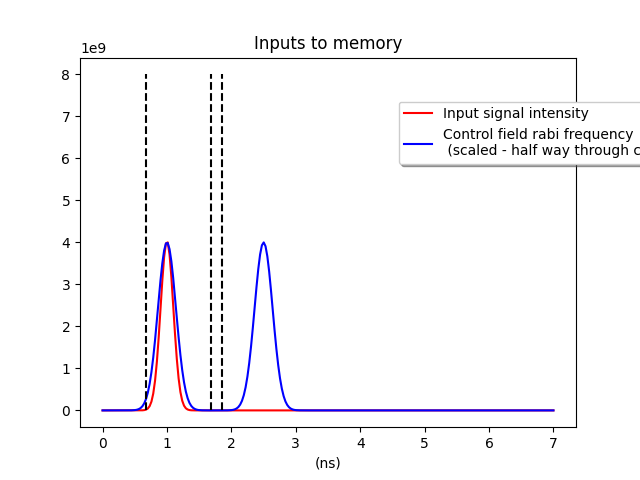

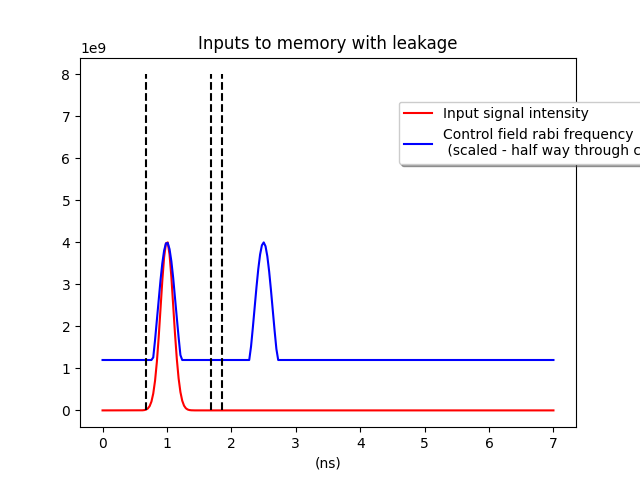

In [10]:
plt.figure()
plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[readincut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.vlines(t[readoutcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.vlines(t[startcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

plt.figure()
plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_CW_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[readincut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.vlines(t[readoutcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.vlines(t[startcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory with leakage')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


## Solve OBE for initial fields

In [11]:
sol.solve(Control_tzp, method='RK4-Ralston')
sol_CW.solve(Control_CW_tzp, method='RK4-Ralston')


## Plot final fields

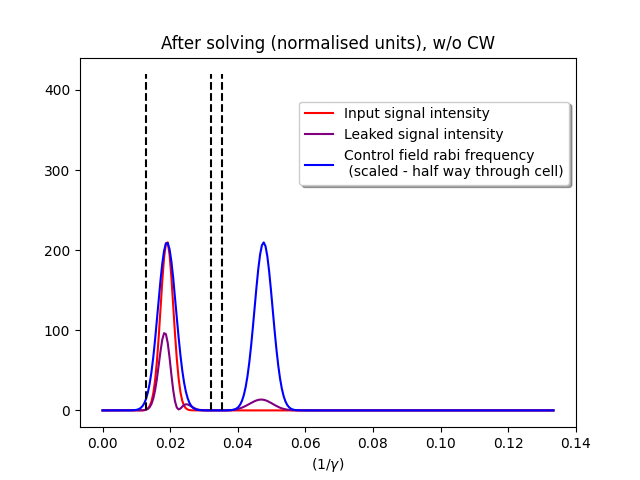

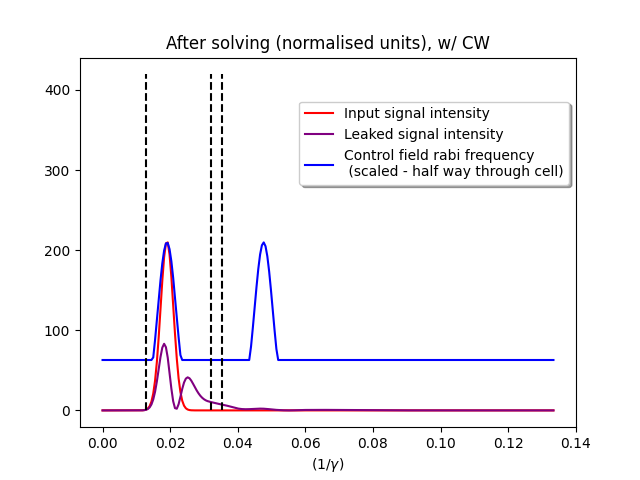

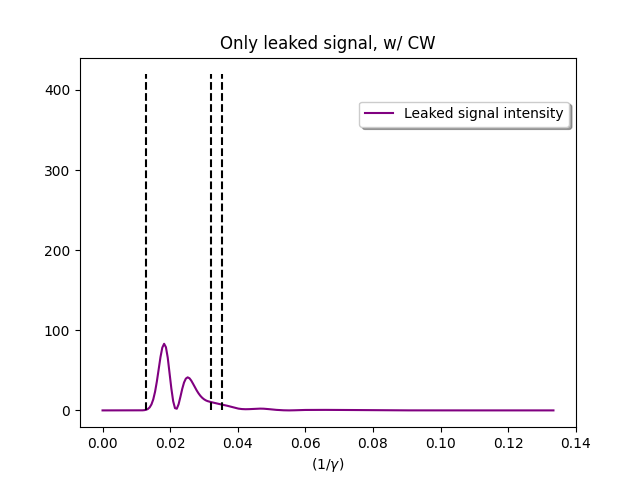

In [14]:
plt.figure()
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[readincut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.vlines(sol.tpoints[readoutcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.vlines(sol.tpoints[startcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units), w/o CW')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

plt.figure()
plt.plot(sol_CW.tpoints, pow(np.abs(sol_CW.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol_CW.tpoints, pow(np.abs(sol_CW.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol_CW.tpoints, (pow(max(np.abs(sol_CW.E[:, 0, 0])), 2)/Omega_store)*Control_CW_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol_CW.tpoints[readincut], 0, 2*max(pow(np.abs(sol_CW.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.vlines(sol_CW.tpoints[readoutcut], 0, 2*max(pow(np.abs(sol_CW.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.vlines(sol_CW.tpoints[startcut], 0, 2*max(pow(np.abs(sol_CW.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units), w/ CW')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

plt.figure()
plt.plot(sol_CW.tpoints, pow(np.abs(sol_CW.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.vlines(sol_CW.tpoints[readincut], 0, 2*max(pow(np.abs(sol_CW.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.vlines(sol_CW.tpoints[readoutcut], 0, 2*max(pow(np.abs(sol_CW.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.vlines(sol_CW.tpoints[startcut], 0, 2*max(pow(np.abs(sol_CW.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('Only leaked signal, w/ CW')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()


## Get efficiencies

In [15]:
eff_readin = sol.storage_efficiency(sol.S, readincut)   
eff_readin_CW = sol_CW.storage_efficiency(sol_CW.S, readincut)


eff_total_readoutcut = sol.retrieval_efficiency(sol.E, readoutcut, m-1, 0)
eff_total_readincut = sol.retrieval_efficiency(sol.E, readincut, readoutcut, 0)
eff_total_CW_readoutcut = sol_CW.retrieval_efficiency(sol_CW.E, readoutcut, m-1, 0)
eff_total_CW_readincut = sol_CW.retrieval_efficiency(sol_CW.E, readincut, readoutcut, 0)

print("Storage Efficiency = " + str(eff_readin))
print("Total Efficiency = " + str(eff_total_readoutcut))
print("Readout Efficiency = " + str(eff_total_readoutcut/eff_readin))
print("Leakage inbetween windows = " + str(eff_total_readincut))
print('\n')
print("Storage Efficiency with CW = " + str(eff_readin_CW))
print("Total Efficiency with CW = " + str(eff_total_CW_readoutcut))
print("Readout Efficiency with CW = " + str(eff_total_CW_readoutcut/eff_readin_CW))
print("Leakage inbetween windows with CW = " + str(eff_total_CW_readincut))

Storage Efficiency = 0.4346909511457619
Total Efficiency = 0.11447935682634354
Readout Efficiency = 0.2633580398317424
Leakage inbetween windows = 7.597146227163289e-06


Storage Efficiency with CW = 0.30221446399106533
Total Efficiency with CW = 0.05643952797672502
Readout Efficiency with CW = 0.1867532322291285
Leakage inbetween windows with CW = 0.024096813422373492


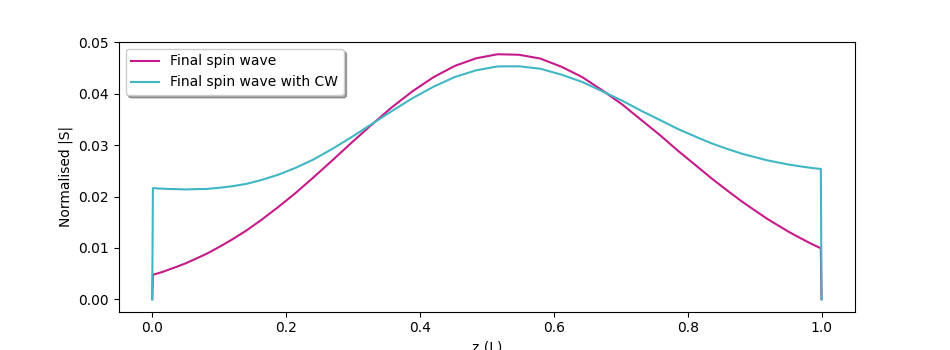

In [16]:
fig, ax = plt.subplots(figsize=(9.5, 3.5))

# ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
# ax.plot(sol_CW.zCheby, np.abs(sol_CW.S[0, :, 0, 0, 0, 0, 0]), color='#a1dab4ff', label='Initial spin wave with CW')
ax.plot(sol_CW.zCheby, np.abs(sol_CW.S[-1, :, 0, 0, 0, 0, 0]), color='#41b6c4ff', label='Final spin wave with CW')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.show()

### Estimate Rabi of pulses and background

In [ ]:
intensity_background_CW = 7.4 # mW
intensity_pulses = 400 # mW

beam_radius = 150e-6 # m

print("Rabi freq. w/o pulses in GHz:", atom.power_to_rabi_frequency(intensity_background_CW, beam_radius)/(2*np.pi*1e9))
print("Rabi freq. of pulses in GHz:", atom.power_to_rabi_frequency(intensity_pulses, beam_radius)/(2*np.pi*1e9))

### Sweep Rabi freq. and obtain efficiencies

In [ ]:
## Parameters

protocol = 'ORCA'


OD = 13700 # Optical depth
#BW = 2*np.pi*1e9
tau = 0.3e-9 # FWHM of signal pulse
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9 # detuning from intermediate state

deltaS = -detuning 
deltaC = detuning

L = 0.13

t0 = 1e-9 # centre of first signal pulse
tend = 4e-9
tbounds = np.array([0, tend])

m = 300 # number of time steps
t = np.linspace(0, tend, m)



photon_pol = np.array([1, 0]) #polarization of photon
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # input signal

Sinits = np.zeros((n, 1, 1, 1, 1, vno))


tr = 1e-9 # storage time
control_pol = np.array([1, 0])

readincut = np.where(t > (t0 + 1*tau))[0][0]
readoutcut = np.where(t > (t0 + tr - tau))[0][0]

rabi_array = np.linspace(1, 10, 100)*1e9


In [ ]:
eff_readin_list = []
eff_total_readoutcut_list = []
eff_total_inbetween_list = []



for rabi in tqdm(rabi_array):


    Control_store = S.gaussian(t, t0, tau, rabi) # control field for storage
    Control_retrieve = S.gaussian(t, t0+tr, tau, rabi) # control field for retrieval

    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    eff_readin = sol.storage_efficiency(sol.S, readincut)   
    eff_readin_list.append(eff_readin)

    eff_total_readoutcut = sol.retrieval_efficiency(sol.E, readoutcut, m-1, 0)
    eff_total_inbetween = sol.retrieval_efficiency(sol.E, readincut, readoutcut, 0)
    eff_total_readoutcut_list.append(eff_total_readoutcut)
    eff_total_inbetween_list.append(eff_total_inbetween)






In [ ]:
eff_readin_CW_list = []
eff_total_CW_readoutcut_list = []
eff_total_CW_inbetween_list = []



for rabi in tqdm(rabi_array):

    Omega_CW = 0.3*rabi

    Control_store = S.gaussian(t, t0, tau, rabi) # control field for storage
    Control_retrieve = S.gaussian(t, t0+tr, tau, rabi) # control field for retrieval
    Control_sum = Control_store + Control_retrieve
    for time in range(m):
        if Control_sum[time] < Omega_CW:
            Control_sum[time] = Omega_CW



    Control_tp = (Control_sum)[:, None] * control_pol[None, :]

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    eff_readin = sol.storage_efficiency(sol.S, readincut)   
    eff_readin_CW_list.append(eff_readin)

    eff_total_readoutcut = sol.retrieval_efficiency(sol.E, readoutcut, m-1, 0)
    eff_total_inbetween = sol.retrieval_efficiency(sol.E, readincut, readoutcut, 0)
    eff_total_CW_readoutcut_list.append(eff_total_readoutcut)
    eff_total_CW_inbetween_list.append(eff_total_inbetween)






In [ ]:
# Plot

plt.figure()
plt.plot(rabi_array/1e9, eff_readin_list, color='red', label='Storage Efficiency')
plt.plot(rabi_array/1e9, eff_total_readoutcut_list, color='blue', label='Total Efficiency')
plt.plot(rabi_array/1e9, eff_total_inbetween_list, color='purple', label='Leakage inbetween windows')
plt.title('Efficiency vs Control Rabi Frequency')
plt.xlabel('Control Rabi Frequency (GHz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


In [ ]:
# Plot

plt.figure()
plt.plot(rabi_array/1e9, eff_readin_CW_list, color='red', label='Storage Efficiency')
plt.plot(rabi_array/1e9, eff_total_CW_readoutcut_list, color='blue', label='Total Efficiency')
plt.plot(rabi_array/1e9, eff_total_CW_inbetween_list, color='purple', label='Leakage inbetween windows')
plt.title('Efficiency vs Control Rabi Frequency with CW')
plt.xlabel('Control Rabi Frequency (GHz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

In [ ]:
plt.figure()
plt.plot(rabi_array/1e9, eff_readin_list, color='red', label='Storage Efficiency')
plt.plot(rabi_array/1e9, eff_readin_CW_list, color='blue', label='Storage Efficiency with CW')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()